# Developing an AI application¶

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application.

In [16]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, tensor, optim
from torch.optim import lr_scheduler

import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms
import torchvision.models as models

import argparse
from collections import OrderedDict
import json
import PIL
import seaborn as sns
from PIL import Image
import time
import copy

# Load the data
The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.
The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's $$[0.485, 0.456, 0.406]$$ and for the standard deviations $$[0.229, 0.224, 0.225]$$, calculated from the ImageNet images. These values will shift each color channel to be centered at 0 and range from -1 to 1.


In [17]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [18]:
#Define your transforms for the training, validation, and testing sets

train_data_transforms = transforms.Compose ([transforms.RandomRotation (30),
                                             #The transform RandomResizedCrop crops the input image by a random size.
                                             transforms.RandomResizedCrop (224),
                                             #RandomHorizontalFlip randomly flips the image horizontally with a 
                                             #default probability of 50%.
                                             transforms.RandomHorizontalFlip (),
                                             transforms.ToTensor (),
                                             #Normalize takes in a 3 channel Tensor and normalizes each channel by
                                             #the input mean and standard deviation for the channel.and Each channel
                                             #in the tensor is normalized as T = (T – mean)/(standard deviation)
                                             transforms.Normalize ([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                            ])
#All the above transformations are chained together using Compose.



valid_data_transforms = transforms.Compose ([transforms.Resize (255),
                                             #CenterCrop crops an 224×224 image from the center.
                                             #Note that for the validation and test data, do not do the RandomResize
                                             #dCrop and RandomHorizontalFlip transformations. 
                                             #Instead,we just resize the validation images and crop out the center in
                                             #order to be able to use them with the pretrained model.
                                             transforms.CenterCrop (224),
                                             transforms.ToTensor (),
                                             transforms.Normalize ([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                            ])

test_data_transforms = transforms.Compose ([transforms.Resize (255),
                                             transforms.CenterCrop (224),
                                             transforms.ToTensor (),
                                             transforms.Normalize ([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                            ])


In [19]:
#Load the datasets with ImageFolder
train_image_datasets = datasets.ImageFolder(train_dir, transform = train_data_transforms)
valid_image_datasets = datasets.ImageFolder(valid_dir, transform = valid_data_transforms)
test_image_datasets = datasets.ImageFolder(test_dir, transform = test_data_transforms)

#Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_image_datasets, batch_size = 64, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_image_datasets, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_image_datasets, batch_size = 64, shuffle = True)

In [20]:
# Size of Loaders, to be used for calculating Average Loss and Accuracy
train_Loader_size = len(train_loader)
valid_Loader_size = len(valid_loader)
test_loader_size = len(test_loader)

# Print the train, validation and test set data sizes
train_Loader_size, valid_Loader_size, test_loader_size

(103, 13, 13)

# Label mapping
You'll also need to load in a mapping from category label to category name. You can find this in the file cat_to_name.json. It's a JSON object which you can read in with the json module. This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [6]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier
Now that the data is ready, it's time to build and train the classifier. Will be using a pretrain Pytorch model from
**torchvision.models** to get image features. Model will be built and trained with a new feed-forward classifier using those features


In [7]:
# Load pretrained model
model = models.vgg16(pretrained=True)


In [8]:
#Freeze feature parameters so as not to backpropagate through them
for param in model.parameters():
    param.requires_grad = False

In [9]:
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096, bias=True)),
                          ('relu1', nn.ReLU()),
                          ('dropout1', nn.Dropout(p=0.5)),
                          ('fc2', nn.Linear(4096, 102, bias=True)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
model.classifier = classifier


In [10]:
# Device agnostic code, automatically uses CUDA if it's enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [11]:
# change to device
model.to(device);

In [12]:
# Criterion chosen has recommended for Log Softmax output.
criterion = nn.NLLLoss()

# Reference for choosing suitable learning rate
# https://medium.com/octavian-ai/which-optimizer-and-learning-rate-should-i-use-for-deep-learning-5acb418f9b2
optimizer = optim.Adam(model.classifier.parameters(),lr=0.001)

In [13]:
# Scheduler based on PyTorch documentation https://pytorch.org/docs/stable/optim.html
scheduler = lr_scheduler.StepLR(optimizer,step_size=4,gamma=0.1,last_epoch=-1)

# Define deep learning method
epochs = 5
print_every = 30 # Prints every 30 images out of batch of 50 images
steps = 0

In [14]:
# Implement a function for the validation pass
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    
    for ii, (inputs, labels) in enumerate(test_loader):
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        output = model.forward(inputs)
        test_loss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [15]:
#Train the classifier layers using backpropogation using the pre-trained network to get features

print("Training process initializing .....\n")

for e in range(epochs):
    running_loss = 0
    model.train() # Technically not necessary, setting this for good measure
    
    for ii, (inputs, labels) in enumerate(train_loader):
        steps += 1
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            model.eval()

            with torch.no_grad():
                valid_loss, accuracy = validation(model, valid_loader, criterion)
            
            print("Epoch: {}/{} | ".format(e+1, epochs),
                  "Training Loss: {:.4f} | ".format(running_loss/print_every),
                  "Validation Loss: {:.4f} | ".format(valid_loss/len(test_loader)),
                  "Validation Accuracy: {:.4f}".format(accuracy/len(test_loader)))
            
            running_loss = 0
            model.train()

print("\nTraining process is now complete!!")

Training process initializing .....

Epoch: 1/5 |  Training Loss: 5.1655 |  Validation Loss: 2.3384 |  Validation Accuracy: 0.4524
Epoch: 1/5 |  Training Loss: 2.4610 |  Validation Loss: 1.3501 |  Validation Accuracy: 0.6399
Epoch: 1/5 |  Training Loss: 2.0068 |  Validation Loss: 1.0218 |  Validation Accuracy: 0.7147
Epoch: 2/5 |  Training Loss: 0.9390 |  Validation Loss: 0.9188 |  Validation Accuracy: 0.7481
Epoch: 2/5 |  Training Loss: 1.5340 |  Validation Loss: 0.8198 |  Validation Accuracy: 0.7776
Epoch: 2/5 |  Training Loss: 1.4421 |  Validation Loss: 0.6629 |  Validation Accuracy: 0.8269
Epoch: 3/5 |  Training Loss: 0.1583 |  Validation Loss: 0.7003 |  Validation Accuracy: 0.8100
Epoch: 3/5 |  Training Loss: 1.3056 |  Validation Loss: 0.5937 |  Validation Accuracy: 0.8269
Epoch: 3/5 |  Training Loss: 1.2643 |  Validation Loss: 0.5378 |  Validation Accuracy: 0.8488
Epoch: 3/5 |  Training Loss: 1.2350 |  Validation Loss: 0.5615 |  Validation Accuracy: 0.8374
Epoch: 4/5 |  Training 

# Testing your network
It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained wel

In [22]:
# Do validation on the test set
correct = 0
total = 0
with torch.no_grad():
    model.eval()
    for data in train_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))

Accuracy achieved by the network on test images is: 81%


# Save the checkpoint

In [24]:
#Save the checkpoint 
model.class_to_idx = train_image_datasets.class_to_idx


In [26]:
checkpoint = {#'architecture': model.name,
             'classifier': model.classifier,
             'class_to_idx': model.class_to_idx,
             'state_dict': model.state_dict()}

torch.save(checkpoint, 'my_checkpoint.pth')

# Loading the checkpoint
At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [27]:
# Write a function that loads a checkpoint and rebuilds the model
# Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint():
    """
    Loads deep learning model checkpoint.
    """
    
    # Load the saved file
    checkpoint = torch.load("'my_checkpoint.pth")
    
    # Download pretrained model
    model = models.vgg16(pretrained=True);
    
    # Freeze parameters so we don't backprop through them
    for param in model.parameters(): param.requires_grad = False
    
    # Load stuff from checkpoint
    model.class_to_idx = checkpoint['class_to_idx']
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])

    
    return model

# Image Preprocessing
You'll want to use PIL to load the image . It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training.

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the thumbnail or resize methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so np_image = np.array(pil_image).

As before, the network expects the images to be normalized in a specific way. For the means, it's [0.485, 0.456, 0.406] and for the standard deviations [0.229, 0.224, 0.225]. You'll want to subtract the means from each color channel, then divide by the standard deviation.

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using ndarray.transpose. The color channel needs to be first and retain the order of the other two dimensions.


In [56]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''

    test_image = PIL.Image.open(image)

    # Get original dimensions
    orig_width, orig_height = test_image.size

    # Find shorter size and create settings to crop shortest side to 256
    if orig_width < orig_height: resize_size=[256, 256*600]
    else: resize_size=[256*600, 256]
        
    test_image.thumbnail(size=resize_size)

    # Find pixels to crop on to create 224x224 image
    center = orig_width/4, orig_height/4
    left, top, right, bottom = center[0]-(244/2), center[1]-(244/2), center[0]+(244/2), center[1]+(244/2)
    test_image = test_image.crop((left, top, right, bottom))

    # Converrt to numpy - 244x244 image w/ 3 channels (RGB)
    np_image = np.array(test_image)/255 # Divided by 255 because imshow() expects integers (0:1)!!

    # Normalize each color channel
    normalise_means = [0.485, 0.456, 0.406]
    normalise_std = [0.229, 0.224, 0.225]
    np_image = (np_image-normalise_means)/normalise_std
        
    # Set the color to the first channel
    np_image = np_image.transpose(2, 0, 1)
    
    return np_image

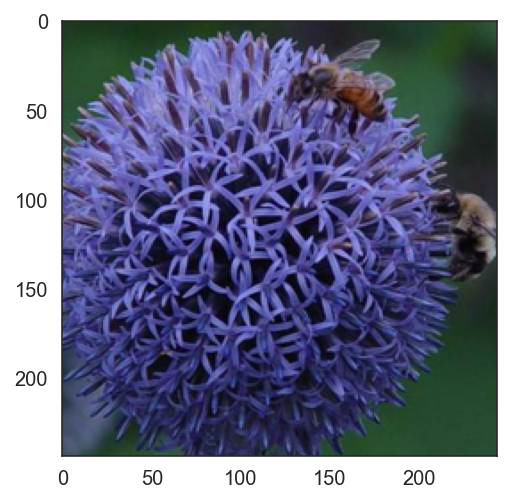

In [57]:
# Test functions on an example
imshow(process_image("flowers/test/10/image_07090.jpg"));

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your process_image function works, running the output through this function should return the original image (except for the cropped out portions).

In [58]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

# Class Prediction

In [59]:
def predict(image_path, model, top_k=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    
    image_path: string. Path to image, directly to image and not to folder.
    model: pytorch neural network.
    top_k: integer. The top K classes to be calculated
    
    returns top_probabilities(k), top_labels
    '''
    
    # No need for GPU on this part (just causes problems)
    model.to("cpu")
    
    # Set model to evaluate
    model.eval();

    # Convert image from numpy to torch
    torch_image = torch.from_numpy(np.expand_dims(process_image(image_path), 
                                                  axis=0)).type(torch.FloatTensor).to("cpu")

    # Find probabilities (results) by passing through the function (note the log softmax means that its on a log scale)
    log_probs = model.forward(torch_image)

    # Convert to linear scale
    linear_probs = torch.exp(log_probs)

    # Find the top 5 results
    top_probs, top_labels = linear_probs.topk(top_k)
    
    # Detatch all of the details
    top_probs = np.array(top_probs.detach())[0] # This is not the correct way to do it but the correct way isnt working thanks to cpu/gpu issues so I don't care.
    top_labels = np.array(top_labels.detach())[0]
    
    # Convert to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labels]
    top_flowers = [cat_to_name[lab] for lab in top_labels]
    
    return top_probs, top_labels, top_flowers

# Sanity Checking

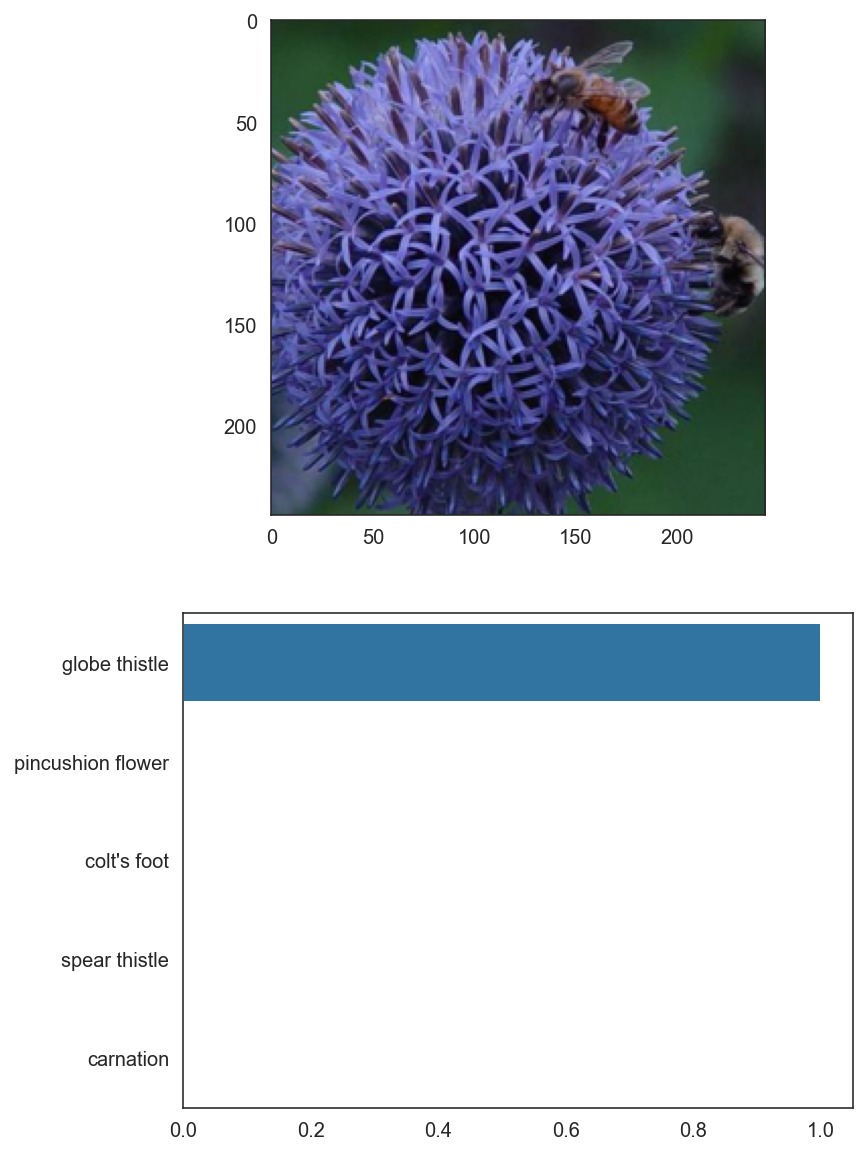

In [60]:
#Display an image along with the top 5 classes
# Define image path
image_path = "flowers/test/10/image_07090.jpg"

# Set up plot
plt.figure(figsize = (6,10))
ax = plt.subplot(2,1,1)

# Set up title
flower_num = image_path.split('/')[2]
title_ = cat_to_name[flower_num]

# Plot flower
img = process_image(image_path)
imshow(img, ax, title = title_);

# Make prediction
probs, labs, flowers = predict(image_path, model) 

# Plot bar chart
plt.subplot(2,1,2)
sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
plt.show()
